In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import os
import struct
import nltk
#nltk.download() 
from nltk.tag import pos_tag # pos_tag shows the characteristic of a word 
                             # using information in the database

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Install Empath tool for analyzing text across lexical categories
import sys
!{sys.executable} -m pip install empath

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
from empath import Empath

In [5]:
import nltk
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to D:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Loading

In [6]:
df = pd.read_csv("./data/Combined_News_DJIA.csv", header = 0, index_col = 0)

In [7]:
df.tail()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,Weapons shipped into Jordan by the CIA and Sau...,...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,UK's Osborne: 'Absolutely' going to have to cu...,...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,Afghan suicide bomber 'kills up to 40' - BBC News,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
2016-07-01,1,A 117-year-old woman 

In [8]:
df.shape

(1989, 26)

In [9]:
headlines = df.as_matrix(columns = df.columns[1:])

In [10]:
headlines.shape

(1989L, 25L)

In [11]:
headlines[0][0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

### Data Loading - Sentiment Tag

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for daily in headlines:
    for line in daily:
        pol_score = sia.polarity_scores(str(line))
        pol_score['headline'] = str(line)
        results.append(pol_score)

C:\ProgramData\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [13]:
sentiment_score_df = pd.DataFrame.from_records(results)

In [14]:
sentiment_score_df.head()

,compound,headline,neg,neu,pos
0,-0.5994,"b""Georgia 'downs two Russian warplanes' as cou...",0.262,0.738,0.0
1,0.0000,b'BREAKING: Musharraf to be impeached.',0.000,1.000,0.0
2,-0.3612,b'Russia Today: Columns of troops roll into So...,0.172,0.828,0.0
3,-0.7089,b'Russian tanks are moving towards the capital...,0.247,0.753,0.0
4,-0.9260,"b""Afghan children raped with 'impunity,' U.N. ...",0.424,0.576,0.0


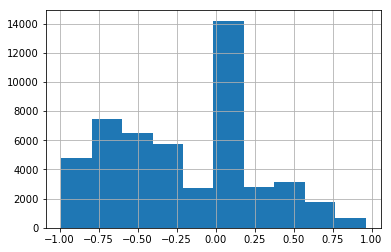

In [15]:
sentiment_score_df['compound'].hist()

In [16]:
daily_avg_sentiment_score = np.mean(sentiment_score_df['compound'].values.reshape(-1, 25), axis = 1)

In [17]:
len(daily_avg_sentiment_score)

1989

(array([  11.,   39.,  187.,  353.,  553.,  482.,  263.,   82.,   15.,    4.]),
 array([-0.520204 , -0.4549512, -0.3896984, -0.3244456, -0.2591928,
        -0.19394  , -0.1286872, -0.0634344,  0.0018184,  0.0670712,
         0.132324 ]),
 <a list of 10 Patch objects>)

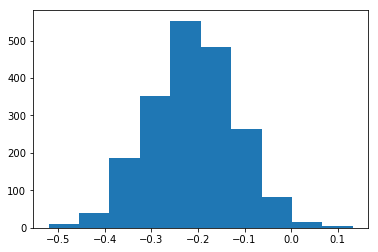

In [18]:
plt.hist(daily_avg_sentiment_score)

In [19]:
df.Label.value_counts()

1    1065
0     924
Name: Label, dtype: int64

In [20]:
daily_avg_sentiment_score = pd.DataFrame(daily_avg_sentiment_score, index=df.index, columns=["daily sentiment score"])

In [21]:
daily_avg_sentiment_score.head()

,daily sentiment score
Date,
2008-08-08,-0.309440
2008-08-11,-0.120740
2008-08-12,-0.217556
2008-08-13,-0.168724
2008-08-14,-0.130748


In [22]:
daily_avg_sentiment_score['label'] = 0
daily_avg_sentiment_score.loc[daily_avg_sentiment_score["daily sentiment score"] > 0.2, 'label'] = 1
daily_avg_sentiment_score.loc[daily_avg_sentiment_score["daily sentiment score"] < -0.2, 'label'] = -1
daily_avg_sentiment_score.head()

,daily sentiment score,label
Date,,
2008-08-08,-0.309440,-1
2008-08-11,-0.120740,0
2008-08-12,-0.217556,-1
2008-08-13,-0.168724,0
2008-08-14,-0.130748,0


In [23]:
daily_avg_sentiment_score.label.value_counts()

-1    1086
 0     903
Name: label, dtype: int64

In [24]:
np.sum(df.Label.values == (daily_avg_sentiment_score.label.values + 1))

1009

In [25]:
np.sum(df.Label != (daily_avg_sentiment_score.label.values + 1))

980

### Data Loading - Topic Filter

In [27]:
from empath import Empath
lexicon = Empath()
categories = lexicon.analyze("he hit the other person", normalize=True)
lexicon.analyze("he hit the other person", categories=['economics', 'technology', 'politics'], normalize=True)
topic_results = []

for daily in headlines:
    for line in daily:
        topic_score = lexicon.analyze(str(line), categories=['economics', 'technology', 'politics'], normalize=True)
        topic_score['headline'] = str(line)
        topic_results.append(topic_score)

In [37]:
topic_score_df = pd.DataFrame.from_records(topic_results)

In [38]:
np.sum(topic_score_df.economics != 0.)

3512

In [39]:
df.iloc[0][19]

"b'This is a busy day:  The European Union has approved new sanctions against Iran in protest at its nuclear programme.'"

In [40]:
len(headlines)

1989

In [41]:
filtered_topic_score_df = topic_score_df.loc[topic_score_df[['economics', 'technology', 'politics']].any( axis = 1)]
fdf = filtered_topic_score_df
fdf.iloc[0][1]

"b'This is a busy day:  The European Union has approved new sanctions against Iran in protest at its nuclear programme.'"

In [42]:
headlinesf = [0]*len(headlines)
for i in range(len(headlines)):
    headlinesf[i] = []
    for j in range(25):
        if (df.iloc[i][j+1] in fdf.values):
            headlinesf[i].append(df.iloc[i][j+1])
headlinesf[0]

["b'This is a busy day:  The European Union has approved new sanctions against Iran in protest at its nuclear programme.'"]

In [43]:
headlines2 = headlinesf

In [60]:
headlines =[''.join(map(str, headline)) for headline in headlines]

In [61]:
# By the end of this step, we have two list, "headlines" and "headlines2".
# "headlines" contains all the headlines joined everyday.
# "headlines2" contains only the topic filtered headlines joined everyday.

## Tokenization
### Tokenization - Basic Settings

In [62]:
# Remove some minor problems in form.
def small_clean(text):
    text = text.replace('b\'', '')
    text = text.replace('b"', '')
    text = text.replace('*', '')
    text = text.replace('\\','')
    text = text.replace('\'','')
    return text

In [63]:
# Single words that we think may be meaningful.
good_pos_tag_set = set(['JJ','JJR','JJS', # adjective
                        'NN','NNP','NNS','NNPS', # noun
                        'RB','RBR','RBS','RP', # adverb and particle
                        'VB','VBD','VBG','VBN','VBP','VBZ']) # verb

In [64]:
# The following two functions are used to help extract terminology and meaningful words
# REFERENCE: http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda (word,pos,chunk): chunk != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]

def extract_candidate_words(text, good_tags=good_pos_tag_set):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word)]

    return candidates

# Pack the word extraction process. Return the list of terms and good words
def tokenize_pack(text):
    text = small_clean(text)
    wordlist = extract_candidate_words(text, good_tags=good_pos_tag_set)
    termlist = extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}')
    finallist = wordlist + termlist
    return finallist

### Tokenization - Vocabulary Construction

In [65]:
# In this part we construct a vocabulary which contains two types of
# terms: (1) Single words among verbs, nouns, adjectives, adverbs and
# particles, which we believe contain meaningful information. 
# (2) Phases that contains more than one words and refers to a specific
# meaning, for example: "Australian government"
headlines2 =[''.join(map(str, headline)) for headline in headlines2]
for i in range(len(headlines2)):
    headlines2[i] = small_clean(headlines2[i])

In [66]:
headlines2[4]

'The US and Poland have agreed a preliminary deal on plans for the controversial US defence shieldRussia apparently is sabotaging infrastructure to cripple the already battered Georgian military.War in the Caucasus is as much the product of an American imperial drive as local conflicts.'

In [67]:
headlines2_train = headlines2[:1500]
headlines2_test = headlines2[1500:]
DJIA_train = df.Label[:1500].values
DJIA_test = df.Label[1500:].values

In [68]:
# TfidfVectorizer
# Exclude the extremely high frequency words/phases and extremely low frequency words/phases.
tfidfvectorizer_word_candidate = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (1, 1))
tfidfvectorizer_phase_candidate = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 5))
train_word_document_matrix_tfidf = tfidfvectorizer_word_candidate.fit_transform(headlines2_train)
test_word_document_matrix_tfidf = tfidfvectorizer_word_candidate.transform(headlines2_test)
train_phase_document_matrix_tfidf = tfidfvectorizer_phase_candidate.fit_transform(headlines2_train)
test_phase_document_matrix_tfidf = tfidfvectorizer_phase_candidate.transform(headlines2_test)
print train_word_document_matrix_tfidf.shape
print test_word_document_matrix_tfidf.shape
print train_phase_document_matrix_tfidf.shape
print test_phase_document_matrix_tfidf.shape

(1500, 441)
(489, 441)
(1500, 66)
(489, 66)


In [69]:
word_candidate_list = tfidfvectorizer_word_candidate.get_feature_names()
word_final_list = []
for i in range(len(word_candidate_list)):
    posTag = pos_tag([str(word_candidate_list[i])])[0][1]
    isGood = (good_pos_tag_set.union([posTag])==good_pos_tag_set)
    if isGood:
        word_final_list.append(str(word_candidate_list[i]))
print len(word_candidate_list)
print len(word_final_list)

441
351


In [70]:
phase_candidate_list = tfidfvectorizer_phase_candidate.get_feature_names()
phase_final_list = []
phase_all_text = ""
for i in range(len(phase_candidate_list)):
    phase_all_text = phase_all_text + ", " + str(phase_candidate_list[i])
    
phase_final_list = extract_candidate_chunks(phase_all_text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}')
print len(phase_candidate_list)
print len(phase_final_list)

66
19


In [71]:
# final_vocabulary = set(word_final_list + phase_final_list)
final_vocabulary = set(phase_candidate_list)
print len(final_vocabulary)
print final_vocabulary
phase_final_list[1]

66
set([u'by the', u'human rights', u'the internet', u'that it', u'it was', u'at the', u'one of', u'the most', u'for the', u'on the', u'the worlds', u'as the', u'north korea', u'according to', u'to make', u'is the', u'nuclear power', u'have been', u'over the', u'it is', u'the countrys', u'will be', u'plans to', u'of the', u'to pay', u'the world', u'and the', u'after the', u'access to', u'from the', u'united states', u'up to', u'the united', u'with the', u'out of', u'thousands of', u'to the', u'of an', u'the government', u'of its', u'the united states', u'the us', u'prime minister', u'that the', u'the uk', u'in the', u'to help', u'one of the', u'the first', u'in an', u'of their', u'part of', u'nuclear weapons', u'to be', u'more than', u'they are', u'has been', u'year old', u'into the', u'in china', u'the european', u'to have', u'about the', u'against the', u'the country', u'to sell'])


'human rights'

In [73]:
tfidfvectorizer_final = TfidfVectorizer(vocabulary = final_vocabulary, ngram_range = (1, 5))
train_term_document_matrix_tfidf = tfidfvectorizer_final.fit_transform(headlines2_train)
test_term_document_matrix_tfidf = tfidfvectorizer_final.transform(headlines2_test)
print train_term_document_matrix_tfidf.shape
print test_term_document_matrix_tfidf.shape

(1500, 66)
(489, 66)


### Tokenization - Custom Settings

In [50]:
stop_words = []
f = open('./data/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words
# The list "stop_words" has 668 words in it

In [51]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    import re
    text = str(text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [52]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

In [96]:
def tokenizer(text):
    from functools import reduce
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens
def wordToString(ordered_word_list):
    result = ""
    for i in range(len(ordered_word_list)):
        result = result+ordered_word_list[i]+" "
    return result

In [215]:
# "headlines3" is different from "headlines1" in that the sentences
# are cleaned and the useless words are removed
headlines3 = []
for i in range(len(headlines)):
    headlines3.append(wordToString(tokenizer(headlines[i])))
headlines4 = []
for i in range(len(headlines2)):
    headlines3.append(wordToString(tokenizer(headlines2[i])))

TypeError: reduce() of empty sequence with no initial value

In [126]:
headlines3[0]

'georgia owns russian warplanes countries move brink war breaking musharraf impeached russia today columns troops roll south ossetia footage fighting youtube russian tanks moving capital south ossetia reportedly completely destroyed georgian artillery fire afghan children raped impunity official sick three year raped russian tanks entered south ossetia whilst georgia shoots russian jets breaking georgia invades south ossetia russia warned intervene side enemy combatent trials sham salim haman sentenced years longer feel georgian troops retreat osettain capital presumably leaving people killed video prep georgia war russia rice green light israel attack iran veto israeli military ops announcing class action lawsuit behalf american public fbi russia georgia war nyt top story opening ceremonies olympics fucking disgrace proof decline journalism china tells bush stay countries affairs war iii start today georgia invades south ossetia russia involved nato absorb georgia unleash full scale w

## Model Input Settings

In [150]:
# "headlines" here can be replaced by "headlines2" or "headlines3"
headlines_train = headlines[:1500]
headlines_test = headlines[1500:]
DJIA_train = df.Label[:1500].values
DJIA_test = df.Label[1500:].values

In [151]:
# CountVectorizer
basicvectorizer = CountVectorizer(ngram_range=(3,3))
train_term_document_matrix_basic = basicvectorizer.fit_transform(headlines_train)
test_term_document_matrix_basic = basicvectorizer.transform(headlines_test)

In [152]:
# TfidfVectorizer: min_df, max_df and ngram_range are the parameters
# which influence the results a lot
tfidfvectorizer = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 3))
train_term_document_matrix_tfidf = tfidfvectorizer.fit_transform(headlines_train)
test_term_document_matrix_tfidf = tfidfvectorizer.transform(headlines_test)

In [153]:
train_term_document_matrix_tfidf.shape

(1500, 673)

In [154]:
tfidfvectorizer.transform(headlines_test).shape

(489, 673)

## Prediction Models
### Prediction Models - KNN

In [214]:
def KNN(X_train, Y_train, X_test, Y_test, K):
    """
    X_train: term_doc_matrix
    Y_train: list
    X_test: term_doc_matrix
    Y_test: list
    K: integer
    """
    pred_train = np.zeros(len(Y_train), dtype = 'int64')
    pred_test = np.zeros(len(Y_test), dtype = 'int64')
    inverted_index_test = { i[0]:i[1] for i in list(zip(range(len(Y_test)),Y_test))}
    inverted_index_train= { i[0]:i[1] for i in list(zip(range(len(Y_train)),Y_train))}
    sim_score_matrix_K_train = cosine_similarity(X_train, X_train)
    for j in range(sim_score_matrix_K_train.shape[0]):
        highest_K_score_index_train = np.argsort(sim_score_matrix_K_train[j])[-K:]
        DJIA_K_train = [inverted_index_train[idx] for idx in highest_K_score_index_train]
        Prob = (sum(DJIA_K_train)+0.)/len(DJIA_K_train) #smoothing
        if Prob >= 0.5:
            pred_train[j] = 1
        else:
            pred_train[j] = 0
    sim_score_matrix_K =  cosine_similarity(X_test, X_train)
    for j in range(sim_score_matrix_K.shape[0]):
        highest_K_score_index = np.argsort(sim_score_matrix_K[j])[-K:]
        DJIA_K = [inverted_index_train[idx] for idx in highest_K_score_index]
        Prob = (sum(DJIA_K)+0.)/len(DJIA_K) #smoothing
        if Prob >= 0.5:
            pred_test[j] = 1
        else:
            pred_test[j] = 0
    accu_train = np.mean(Y_train == pred_train)        
    accu_test = np.mean(Y_test == pred_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
Knn = KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test,10)
print "KNN Model, K = 10"
print "Training Error:\t",Knn[0]
print "Test Error:\t",Knn[1]

KNN Model, K = 10
Training Error:	0.36
Test Error:	0.451942740286


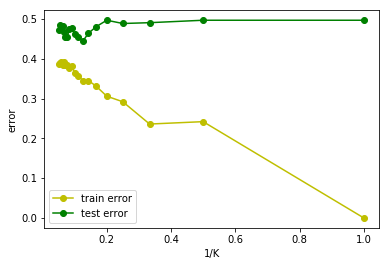

In [211]:
train_error =[KNN(train_term_document_matrix_basic, DJIA_train, test_term_document_matrix_basic, DJIA_test, K)[0] for K in range(1, 20)]
test_error = [KNN(train_term_document_matrix_basic, DJIA_train, test_term_document_matrix_basic, DJIA_test, K)[1] for K in range(1, 20)]
one_over_k = [1.0/K for K in range(1, 20)]
plt.plot(one_over_k, train_error, '-yo', label = 'train error')
plt.plot(one_over_k, test_error, '-go', label = 'test error')
plt.ylabel('error')
plt.xlabel('1/K')
plt.legend(loc = 'lower left')

In [212]:
KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, 10)

(0.35999999999999999, 0.45194274028629855)

In [213]:
np.argmin(test_error)

7

### Prediction Models - Logistic

In [204]:
from sklearn.linear_model import LogisticRegression
def Logit(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression()
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
Logit0 = Logit(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Logistic Model"
print "Training Error:\t",Logit0[0]
print "Test Error:\t",Logit0[1]

Logistic Model
Training Error:	0.236666666667
Test Error:	0.425357873211


In [180]:
def LogitLasso(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression(penalty='l1')
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
LogitL = LogitLasso(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Logistic Lasso Model"
print "Training Error:\t",LogitL[0]
print "Test Error:\t",LogitL[1]

Logistic Lasso Model
Training Error:	0.343333333333
Test Error:	0.486707566462


In [179]:
def LogitRidge(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression(penalty='l2')
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
LogitR = LogitRidge(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Logistic Ridge Model"
print "Training Error:\t",LogitR[0]
print "Test Error:\t",LogitR[1]

Logistic Ridge Model
Training Error:	0.236666666667
Test Error:	0.425357873211


### Prediction Models - Rocchio Classification

In [187]:
def Rocchio(X_train, Y_train, X_test, Y_test):
    pred_train = np.zeros(len(Y_train), dtype = 'int64')
    pred_test = np.zeros(len(Y_test), dtype = 'int64')
    X_train_1 = X_train[np.array(Y_train) == 1, :]
    X_train_0 = X_train[np.array(Y_train) == 0, :]
    Centriod_1 = (np.sum(X_train_1, axis = 0)+0.)/X_train_1.shape[0]
    Centriod_0 = (np.sum(X_train_0, axis = 0)+0.)/X_train_0.shape[0]
    for j in range(len(Y_train)):
        distance_1 = np.sqrt(np.sum(np.square(X_train[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_train[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred_train[j] = 1
        else:
            pred_train[j] = 0
    accu_train = np.mean(Y_train == pred_train)
    for j in range(len(Y_test)):
        distance_1 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred_test[j] = 1
        else:
            pred_test[j] = 0
    accu_test = np.mean(Y_test == pred_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
Rocchio = Rocchio(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Rocchio Classification Model"
print "Training Error:\t",Rocchio[0]
print "Test Error:\t",Rocchio[1]

Rocchio Classification Model
Training Error:	0.27
Test Error:	0.41717791411


### Prediction Models - Naive Bayes

In [184]:
from sklearn.naive_bayes import BernoulliNB
def NaiveBayes(X_train, Y_train, X_test, Y_test):
    BNBclassifier = BernoulliNB(alpha=1)
    BNBclassifier.fit(X_train, Y_train)
    BNBpred_train = BNBclassifier.predict(X_train)
    BNBpred = BNBclassifier.predict(X_test)
    accu_train = np.mean(BNBpred_train==Y_train)
    accu_test = np.mean(BNBpred==Y_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
NBayes = NaiveBayes(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Naive Bayes Model"
print "Training Error:\t",NBayes[0]
print "Test Error:\t",NBayes[1]

Naive Bayes Model
Training Error:	0.260666666667
Test Error:	0.431492842536


### Prediction Models - Decision Tree

In [186]:
# REFERENCE: http://scikit-learn.org/stable/modules/tree.html
from sklearn import tree
def DecisionTree(X_train, Y_train, X_test, Y_test):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, Y_train)
    clf_train = clf.predict(X_train)
    clf_test = clf.predict(X_test)
    accu_train = sum(Y_train == clf_train)/float(len(Y_train))
    accu_test = sum(Y_test == clf_test)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
DTree = DecisionTree(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Decision Tree Model"
print "Training Error:\t",DTree[0]
print "Test Error:\t",DTree[1]

Decision Tree Model
Training Error:	0.0
Test Error:	0.482617586912


### Prediction Models - Random Forests

In [185]:
# REFERENCE: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, Y_train, X_test, Y_test, md):
    clfr = RandomForestClassifier(max_depth=md, random_state=0)
    clfr = clfr.fit(X_train, Y_train)
    clfr_train = clfr.predict(X_train)
    clfr_test = clfr.predict(X_test)
    accu_train = sum(Y_train == clfr_train)/float(len(Y_train))
    accu_test = sum(Y_test == clfr_test)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
RF = RandomForest(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, 10)
print "Random Forests Model, max_depth = 10"
print "Training Error:\t",RF[0]
print "Test Error:\t",RF[1]

Random Forests Model, max_depth = 10
Training Error:	0.223333333333
Test Error:	0.441717791411
